# 一、前期工作

本文将实现灵笼中人物角色的识别。较上一篇文章，这次我采用了VGG-19结构，并增加了**预测**与**保存and加载模型**两个部分。

🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本
- 数据链接：https://pan.baidu.com/s/17CGhYKYkAGkC1wVd2gYGCA （提取码：wn79）

我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2

## 1. 设置GPU

如果使用的是CPU可以忽略这步

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")

## 2. 导入数据

In [2]:
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import os,PIL

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

from tensorflow import keras
from tensorflow.keras import layers,models

import pathlib

In [3]:
data_dir = "D:/jupyter notebook/DL-100-days/datasets/linglong_photos"

data_dir = pathlib.Path(data_dir)

## 3. 查看数据

数据集中一共有白月魁、查尔斯、红蔻、马克、摩根、冉冰等6个人物角色。

|文件夹|	含义|	数量|
|:--:|:--:|:--:|
|baiyuekui|	白月魁|	40 张
|chaersi|	查尔斯|	76 张
|hongkou|	红蔻|	36 张
|make|	马克|	38张
|mogen|	摩根|	30 张
|ranbing|	冉冰|	60张

In [4]:
image_count = len(list(data_dir.glob('*/*')))

print("图片总数为：",image_count)

图片总数为： 280


# 二、数据预处理

## 1. 加载数据

使用`image_dataset_from_directory`方法将磁盘中的数据加载到`tf.data.Dataset`中

In [5]:
batch_size = 16
img_height = 224
img_width = 224

In [6]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 280 files belonging to 6 classes.
Using 252 files for training.


In [7]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 280 files belonging to 6 classes.
Using 28 files for validation.


我们可以通过class_names输出数据集的标签。标签将按字母顺序对应于目录名称。

In [8]:
class_names = train_ds.class_names
print(class_names)

['baiyuekui', 'chaersi', 'hongkou', 'make', 'mogen', 'ranbing']


## 2. 可视化数据

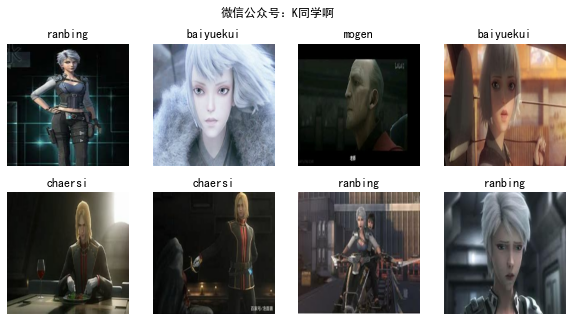

In [9]:
plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("微信公众号：K同学啊")

for images, labels in train_ds.take(1):
    for i in range(8):
        
        ax = plt.subplot(2, 4, i + 1)  

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

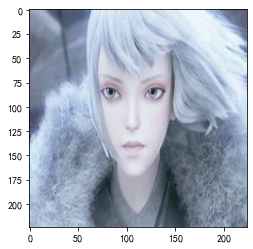

In [10]:
plt.imshow(images[1].numpy().astype("uint8"))

## 3. 再次检查数据 

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16,)


- `Image_batch`是形状的张量（32,180,180,3）。这是一批形状180x180x3的32张图片（最后一维指的是彩色通道RGB）。 
- `Label_batch`是形状（32，）的张量，这些标签对应32张图片

## 4. 配置数据集

- **shuffle()** ： 打乱数据，关于此函数的详细介绍可以参考：https://zhuanlan.zhihu.com/p/42417456
- **prefetch()** ：预取数据，加速运行，其详细介绍可以参考我前两篇文章，里面都有讲解。
- **cache()** ：将数据集缓存到内存当中，加速运行

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 5. 归一化

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalization_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [14]:
image_batch, labels_batch = next(iter(val_ds))
first_image = image_batch[0]

# 查看归一化后的数据
print(np.min(first_image), np.max(first_image))

0.00390696 1.0


# 三、构建VGG-19网络

在官方模型与自建模型之间进行二选一就可以啦，选着一个注释掉另外一个，都是正版的VGG-19哈。

**VGG优缺点分析：**

- **VGG优点**

VGG的结构非常简洁，整个网络都使用了同样大小的卷积核尺寸`（3x3）`和最大池化尺寸`（2x2）`。

- **VGG缺点**

1)训练时间过长，调参难度大。2)需要的存储容量大，不利于部署。例如存储`VGG-16`权重值文件的大小为500多MB，不利于安装到嵌入式系统中。

## 1. 官方模型（已打包好）

官网模型调用这块我放到后面几篇文章中，下面主要讲一下VGG-19

In [15]:
# model = keras.applications.VGG19(weights='imagenet')
# model.summary()

## 2. 自建模型

In [16]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

def VGG19(nb_classes, input_shape):
    input_tensor = Input(shape=input_shape)
    # 1st block
    x = Conv2D(64, (3,3), activation='relu', padding='same',name='block1_conv1')(input_tensor)
    x = Conv2D(64, (3,3), activation='relu', padding='same',name='block1_conv2')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block1_pool')(x)
    # 2nd block
    x = Conv2D(128, (3,3), activation='relu', padding='same',name='block2_conv1')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same',name='block2_conv2')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block2_pool')(x)
    # 3rd block
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='block3_conv1')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='block3_conv2')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='block3_conv3')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='block3_conv4')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block3_pool')(x)
    # 4th block
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block4_conv1')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block4_conv2')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block4_conv3')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block4_conv4')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block4_pool')(x)
    # 5th block
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block5_conv1')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block5_conv2')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block5_conv3')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block5_conv4')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block5_pool')(x)
    # full connection
    x = Flatten()(x)
    x = Dense(4096, activation='relu',  name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    output_tensor = Dense(nb_classes, activation='softmax', name='predictions')(x)

    model = Model(input_tensor, output_tensor)
    return model

model=VGG19(1000, (img_width, img_height, 3))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 3. 网络结构图

关于卷积计算的相关知识可以参考文章：https://mtyjkh.blog.csdn.net/article/details/114278995

**结构说明：**

- 16个卷积层（Convolutional Layer），分别用`blockX_convX`表示
- 3个全连接层（Fully connected Layer），分别用`fcX`与`predictions`表示
- 5个池化层（Pool layer），分别用`blockX_pool`表示

**VGG-19包含了19个隐藏层（16个卷积层和3个全连接层），故称为VGG-19**

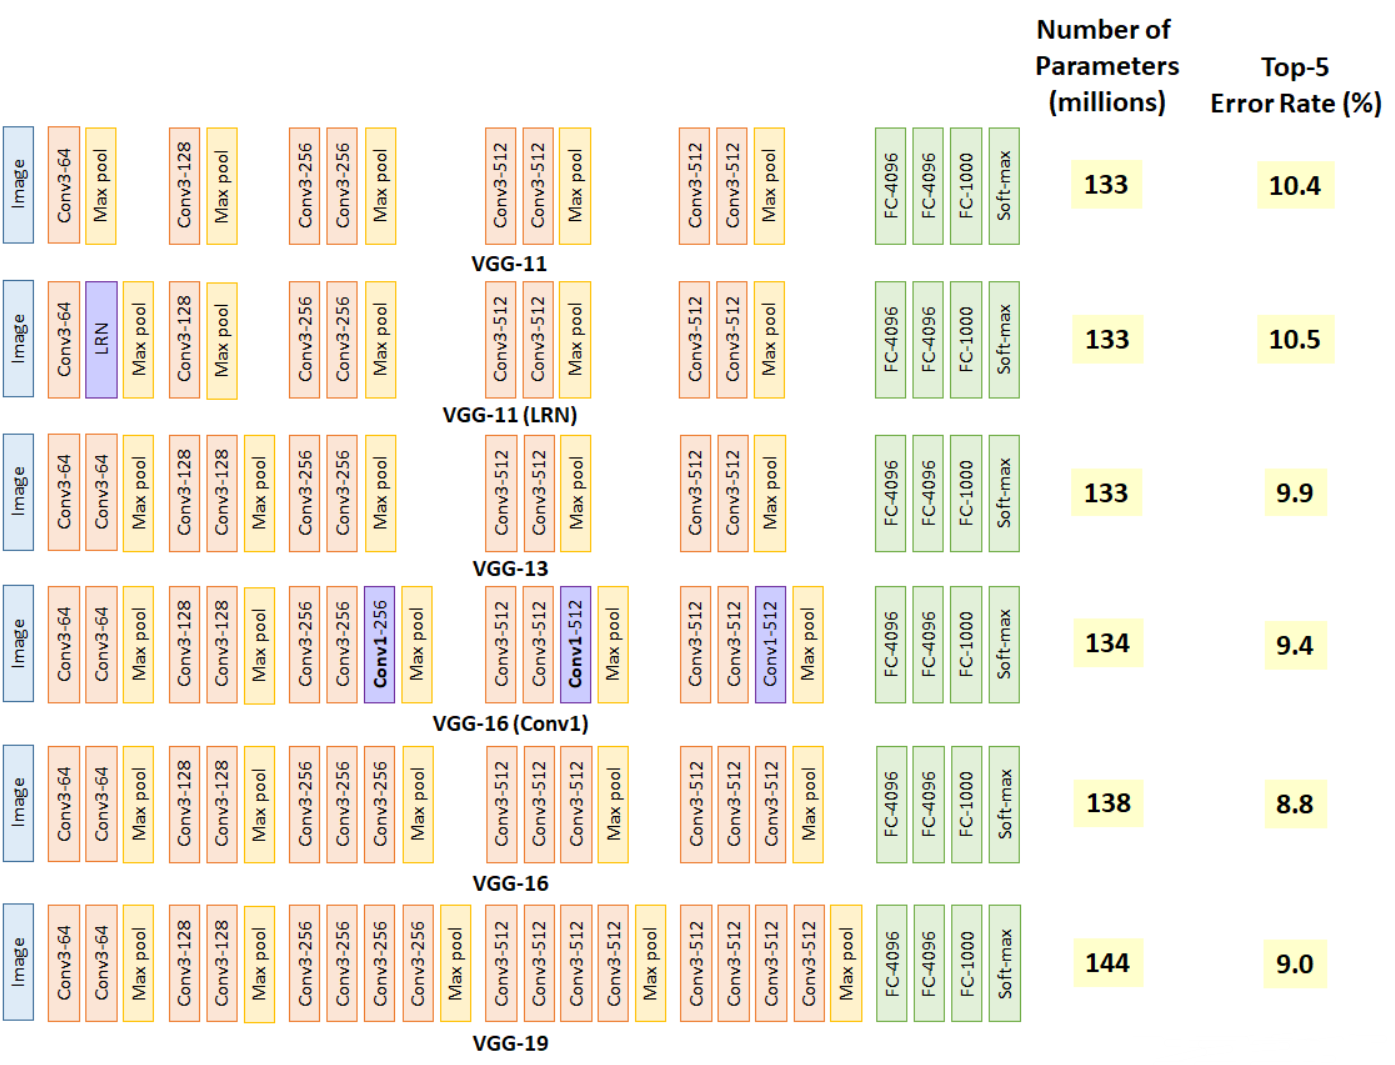

# 四、编译

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

- 损失函数（loss）：用于衡量模型在训练期间的准确率。
- 优化器（optimizer）：决定模型如何根据其看到的数据和自身的损失函数进行更新。
- 指标（metrics）：用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [17]:
# 设置优化器，我这里改变了学习率。
opt = tf.keras.optimizers.Nadam(learning_rate=1e-5)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 五、训练模型

In [18]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
16/16 [==============================] - 21s 274ms/step - loss: 5.4494 - accuracy: 0.1508 - val_loss: 6.8600 - val_accuracy: 0.0714
Epoch 2/10
16/16 [==============================] - 2s 130ms/step - loss: 1.7976 - accuracy: 0.3174 - val_loss: 6.8402 - val_accuracy: 0.3929
Epoch 3/10
16/16 [==============================] - 2s 139ms/step - loss: 1.4882 - accuracy: 0.4201 - val_loss: 6.8453 - val_accuracy: 0.5357
Epoch 4/10
16/16 [==============================] - 2s 135ms/step - loss: 1.1548 - accuracy: 0.5917 - val_loss: 6.8551 - val_accuracy: 0.3571
Epoch 5/10
16/16 [==============================] - 2s 139ms/step - loss: 1.0376 - accuracy: 0.6267 - val_loss: 6.8421 - val_accuracy: 0.4286
Epoch 6/10
16/16 [==============================] - 2s 136ms/step - loss: 1.0189 - accuracy: 0.5942 - val_loss: 6.8277 - val_accuracy: 0.5714
Epoch 7/10
16/16 [==============================] - 2s 133ms/step - loss: 0.6873 - accuracy: 0.7761 - val_loss: 6.8382 - val_accuracy: 0.6429
Epoch

# 六、模型评估

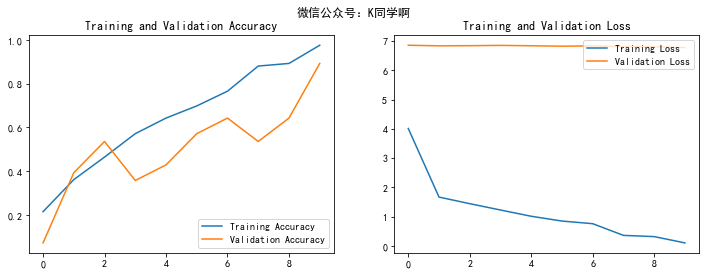

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.suptitle("微信公众号：K同学啊")

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

为体现原汁原味的VGG-19，本文并未对模型参数进行修改，可依据实际情况修改模型中的相关性参数，适应实际情况以便提升分类效果。

较上一篇文章[【学习100例-卷积神经网络（VGG-16）识别海贼王草帽一伙 | 第6天】](https://blog.csdn.net/qq_38251616/article/details/117331631)我做了如下三个改变：

- 将模型从`VGG-16`改为`VGG-19`，
- 将学习率（learning_rate）从`1e-4`改为了`1e-5`
- 更换了数据集

是不是仿佛明白了什么呢

不明白也没关系，后面再逐一讲解，这里先给大家一个体验

# 七、保存and加载模型

这是最简单的模型保存与加载方法哈

In [20]:
# 保存模型
model.save('model/my_model.h5')

In [21]:
# 加载模型
new_model = keras.models.load_model('model/my_model.h5')

# 八、预测

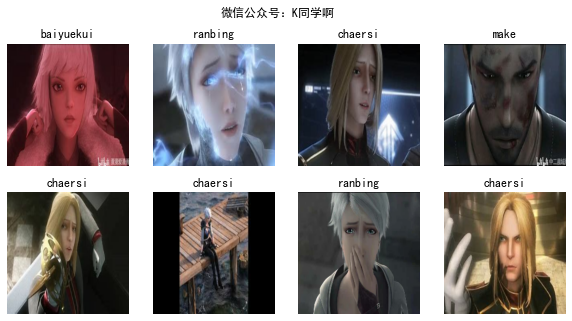

In [22]:
# 采用加载的模型（new_model）来看预测结果

plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("微信公众号：K同学啊")

for images, labels in val_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)  
        
        # 显示图片
        plt.imshow(images[i])
        
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(images[i], 0) 
        
        # 使用模型预测图片中的人物
        predictions = new_model.predict(img_array)
        plt.title(class_names[np.argmax(predictions)])

        plt.axis("off")

VGG-19这篇文章其实埋下了很多坑，我都非常巧妙的将它隐藏起来了不知道大家有没有发现。大家可以将自己发现的问题在下方留言处进行讨论。对于一个完美主义者，这些不完美看着真的好难受。后面看看能不能专门出几篇文章来讲这些内容。

**其他精彩内容：**

- [**深度学习100例-卷积神经网络（CNN）实现mnist手写数字识别 | 第1天**](https://mtyjkh.blog.csdn.net/article/details/116920825)
- [**深度学习100例-卷积神经网络（CNN）彩色图片分类 | 第2天**](https://mtyjkh.blog.csdn.net/article/details/116978213)
- [**深度学习100例-卷积神经网络（CNN）服装图像分类 | 第3天**](https://mtyjkh.blog.csdn.net/article/details/116992196)
- [**深度学习100例-卷积神经网络（CNN）花朵识别 | 第4天**](https://mtyjkh.blog.csdn.net/article/details/117079919)
- [**深度学习100例-卷积神经网络（CNN）天气识别 | 第5天**](https://mtyjkh.blog.csdn.net/article/details/117186183)
- [**深度学习100例-卷积神经网络（VGG-16）识别海贼王草帽一伙 | 第6天**](https://blog.csdn.net/qq_38251616/article/details/117331631)

**《深度学习100例》专栏直达：**[**【传送门】**](https://blog.csdn.net/qq_38251616/category_11068756.html)

**需要数据的同学可以在评论中留下邮箱**，如果觉得本文对你有帮助记得 **点个关注，给个赞，加个收藏**